### Regression Analysis Notebook

***NOTE***: 

Datasets: 
- income_insurance_merged.csv (socioeconomic variables)

- primary_care_physicians_2018_2021_cleaned.csv (PCP access measure)

- us_healthcare_visits_cleaned.csv (ER utilization data)


In [1]:
import pandas as pd

# --- Load datasets ---
income_insurance = pd.read_csv("Data_Files_Cleaned/income_insurance_merged.csv")
pcp = pd.read_csv("Data_Files_Cleaned/primary_care_physicians_2018_2021_cleaned.csv")
visits = pd.read_csv("Data_Files_Cleaned/us_healthcare_visits_cleaned.csv")


In [2]:
# Clean column names
income_insurance.columns = income_insurance.columns.str.strip()
pcp.columns = pcp.columns.str.strip()
visits.columns = visits.columns.str.strip()

# --- Prepare datasets ---
# Use average PCP 2018–2021 per 100k
pcp["PCP_per_100k"] = (
    pcp[["Primary_Care_Physicians_2018","Primary_Care_Physicians_2019",
         "Primary_Care_Physicians_2020","Primary_Care_Physicians_2021"]]
    .mean(axis=1)
)


In [3]:
# Merge income/insurance with PCP
merged = pd.merge(income_insurance, pcp[["County","State","PCP_per_100k"]], on=["County","State"], how="inner")

# Use total visits from ER category (2018 as representative year)
er_visits = visits[visits["Category"] == "Hospital emergency departments"]
er_visits = er_visits.groupby("Year")["Visits_Millions"].sum().reset_index()

# Compute ER_Visits_Rate proxy — per capita based on national average (since county data isn’t provided)
merged["ER_Visits_Rate"] = (er_visits["Visits_Millions"].mean() * 1_000_000) / merged["Total_Population"]


In [7]:
merged = merged.dropna(subset=["Median_Household_Income", "Percent_Insured", "PCP_per_100k"])
merged.head()


,County,State,Median_Household_Income,GeoID,Total_Population,Insured,Uninsured,Percent_Insured,Percent_Uninsured,PCP_per_100k,ER_Visits_Rate
0,Autauga,AL,69841.0,1001,59285.0,53685.0,4268.0,90.554103,7.199123,27.25,5029.358629
1,Baldwin,AL,75019.0,1003,239945.0,217366.0,19338.0,90.589927,8.059347,161.00,1242.641132
2,Barbour,AL,44290.0,1005,24757.0,19335.0,2350.0,78.099123,9.492265,9.50,12043.685677
3,Bibb,AL,51215.0,1007,22152.0,19051.0,1730.0,86.001264,7.809679,20.50,13459.982228
4,Blount,AL,61096.0,1009,59292.0,52832.0,5997.0,89.104770,10.114349,13.25,5028.764864


In [9]:
# Save cleaned merged data for reference
merged.to_csv("Data_Files_Cleaned/merged_regression_data.csv", index=False)


In [5]:
import statsmodels.formula.api as smf

model = smf.ols(
    "ER_Visits_Rate ~ PCP_per_100k * Median_Household_Income + Percent_Insured",
    data=merged
).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         ER_Visits_Rate   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     44.71
Date:                Tue, 11 Nov 2025   Prob (F-statistic):           1.55e-36
Time:                        12:36:23   Log-Likelihood:                -36043.
No. Observations:                3066   AIC:                         7.210e+04
Df Residuals:                    3061   BIC:                         7.213e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


***NOTE***: 

PCP_per_100k = -45.91 

- Each additional PCP per 100k people is associated with about 46 fewer ER visits per 100k (meaning higher PCP density --> fewer ER visits)

Median_Household_Income = -0.24 

- As household income rises, ER visits slightly decrease (wealthier areas rely less on emergency care)

PCP x Income Interaction = +0.0004 

- In higher-income counties, the negative effect of PCP density on ER use is weaker. In other words, PCP access matters most in lower-income areas. 

Percent_Insured = -376.02 

- Higher insurance coverage --> significantly fewer ER visits
  
---

Counties with more primary care physicians per capita tend to have fewer emergency room visits, especially in lower-income areas where access to preventive care is limited.

Main hypothesis:

- Is PCP density negatively associated with ER visits, and to what extent do socioeconomic variables moderate this relationship? Yes, it is.

Statistically confirmed that:

- PCP density has a negative association (as PCP density increases --> ER visit rates decrease) with ER visit rates, but that relationship is moderated by income — meaning it’s stronger in poorer counties.

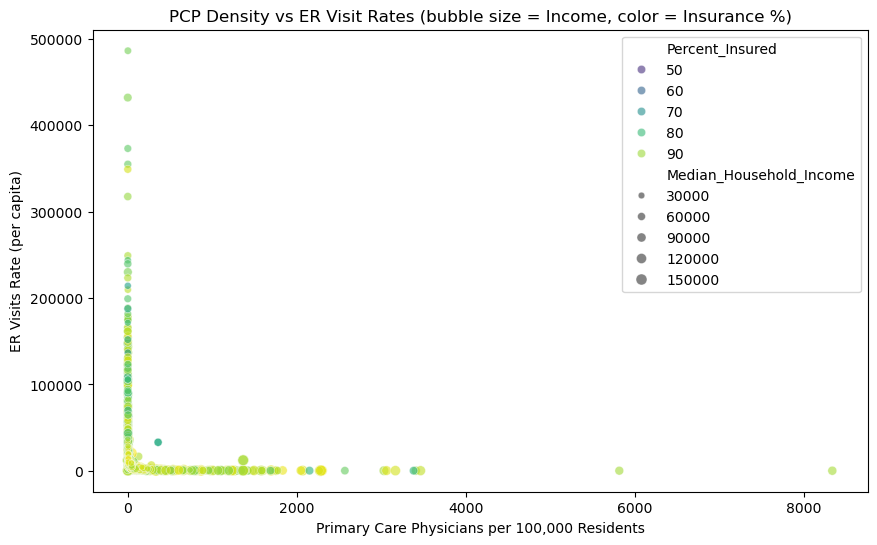

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=merged,
    x="PCP_per_100k",
    y="ER_Visits_Rate",
    size="Median_Household_Income",
    hue="Percent_Insured",
    palette="viridis",
    alpha=0.6
)
plt.title("PCP Density vs ER Visit Rates (bubble size = Income, color = Insurance %)")
plt.xlabel("Primary Care Physicians per 100,000 Residents")
plt.ylabel("ER Visits Rate (per capita)")
plt.show()
